In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
import astropy.units as u
import astropy.constants as c

import random
import os
from scipy.interpolate import interp1d

In [2]:
# define demarcation lines

def kauf_line():
    x=np.linspace(-2, 0, 100)
    y = (0.61/(x - 0.05) + 1.3)
    return x, y

def kewl_line():
    x=np.linspace(-2, 0.4, 100)
    y = (0.61/(x - 0.47) + 1.19)
    return x, y

def law_line():
    x=np.linspace(-0.24, 0.5)
    y = 0.95*x+0.56
    return x, y

In [3]:
# read in BPT data
eboss = pd.read_csv('/Users/quinncasey/pyme/f_agn/data/eboss_bpt.csv')
dfsf = eboss.loc[eboss['gal'] == 'sf']
dfagn = eboss.loc[(eboss['gal'] == 'agn') | (eboss['gal'] == 'lmagn')]
dfr = eboss.loc[(eboss['gal'] != 'sf') | (eboss['gal'] != 'agn') | (eboss['gal'] != 'lmagn')]

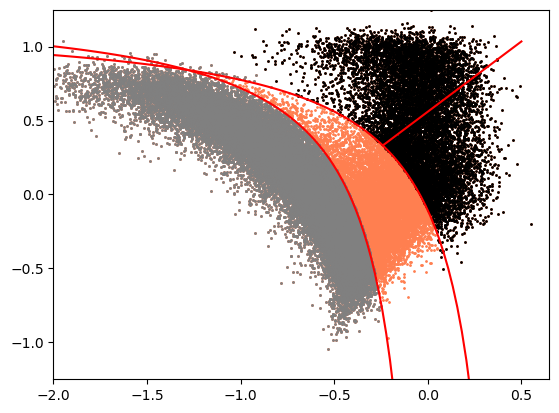

In [4]:
plt.scatter(dfr['x'], dfr['y'], c='coral', s=1)
plt.scatter(dfsf['x'], dfsf['y'], c='gray', s=1)
plt.scatter(dfagn['x'], dfagn['y'], c='k', s=1)
plt.plot(kewl_line()[0], kewl_line()[1], c='r')
plt.plot(kauf_line()[0], kauf_line()[1], c='r')
plt.plot(law_line()[0], law_line()[1], c='r')
plt.xlim(-2, 0.65)
plt.ylim(-1.25, 1.25)
plt.show()

In [5]:
# made points in webplotdigitizer to capture the edge of SFG and AGN land

sfg_100_x = [-1.659804497253981, -1.5419329211426205, -1.4420918103001623, -1.3015439881178543,  -1.2108044627128596, -1.0928983454802945,  -0.9976339331974717,  -0.9114020241097027, -0.8341680770957827,  -0.7660184449587235, -0.6796483713861352,  -0.6249870470795484,  -0.5658526475769405, -0.5202238264654071,  -0.45190148872232405,  -0.3612137749991371]
sfg_100_y = [0.734732824427481, 0.6603053435114505, 0.5629770992366412, 0.47137404580152675, 0.3912213740458017, 0.30534351145038174, 0.22519083969465647, 0.1393129770992365, 0.03625954198473269, -0.055343511450381744, -0.1870229007633588, -0.3072519083969467, -0.41030534351145054, -0.5362595419847329,  -0.6851145038167941, -0.7480916030534357]

agn_100_x = [-0.5113467583157751, -0.4389831093917307, -0.3575696867120306, -0.24448205588753424, -0.1449345445753174, -0.06797692653103526, -0.009067044316259043, 0.04536976270249715, 0.08179337501295247, 0.1181824462022032, 0.13647196988014176, 0.15483057580048998, 0.17771406859866667, 0.20515698939587557, 0.22810956443646102, 0.25553521467306783, 0.27848778971365373, 0.2969672895582183, 0.31991986459880417]
agn_100_y = [1.020992366412214, 1.0324427480916032, 1.0438931297709926, 1.0553435114503817, 1.0553435114503817, 1.0438931297709926, 1.0152671755725193, 0.969465648854962, 0.8950381679389314, 0.8320610687022902, 0.7690839694656489, 0.6832061068702291, 0.5973282442748094, 0.5, 0.3912213740458017, 0.29961832061068705, 0.19083969465648853, 0.06488549618320616, -0.04389312977099258]

sfg_100_func = interp1d(sfg_100_x, sfg_100_y)
agn_100_func = interp1d(agn_100_x, agn_100_y)

In [6]:
# number of  evolution tracks
N = 2500

sfx = np.array(random.sample(list(np.linspace(np.min(sfg_100_x), np.max(sfg_100_x), 10000)), N))
sfy = sfg_100_func(sfx)

agnx = np.array(random.sample(list(np.linspace(np.min(agn_100_x), np.max(agn_100_x), 10000)), N))
agny = agn_100_func(agnx)

balmer_dec = 2.86

# H-alpha caontribution is 1 (doesn't matter bc they are all ratios)
sfha = np.linspace(1, 1, N)
# balmer decrement
sfhb = sfha/balmer_dec
# SFG N2 contribution based of the SFG points and SFG H-alpha
sfn2 = sfha*(10**sfx)
# same idea as sfn2
sfo3 = sfhb*(10**sfy)

# fractional AGN contribution
f = np.linspace(0.0, 0.99, N)

In [7]:
# calculating the AGN O3 contribution for a given f-value
# f = agno3/(sfo3+agno3) ----> ao3 = -f*sfo3/(f-1)
agno3 = []
for index, value in enumerate(sfo3):
        agno3.append((-f[:]*value)/(f[:]-1))

# calculating agn hb, ha, & n2 based on various lines and the agn x & y components
agnhb = []
for index, value in enumerate(agno3):
    agnhb.append(value/(10**agny[index]))

agnha = []
for i in agnhb:
    agnha.append(i*balmer_dec)

agnn2 = []
for index, value in enumerate(agnha):
    agnn2.append(value*(10**agnx[index]))

# calculating the total n2, ha, o3, hb contribution for a given f value 
# n2_tot = agnn2+sfgn2, etc.
n2 = []
for index, value in enumerate(agnn2):
    n2.append(value+sfn2[index])
    
ha = []
for index, value in enumerate(agnha):
    ha.append(value+sfha[index])
    
o3 = []
for index, value in enumerate(agno3):
    o3.append(value+sfo3[index])
    
hb = []
for index, value in enumerate(agnhb):
    hb.append(value+sfhb[index])
    
# translating n2, ha, o3, hb into log x & y space
x = []
for index, value in enumerate(n2):
    x.append(np.log10(value/ha[index]))
    
y = []
for index, value in enumerate(o3):
    y.append(np.log10(value/hb[index]))

In [8]:
# making array with x/y and f values
xs = []
ys = []
for i in range(N):
    xs.append((np.array( x[i][:]), f))                          
    ys.append((np.array( y[i][:]), f))

In [9]:
#  putting x/y values in df where the index number is the fractional AGN contribution
dfx = pd.DataFrame({})
dfy = pd.DataFrame({})
for i in range(N):
    dfx[i] = xs[i][0]
    dfx = dfx.set_index(xs[i][1])
    dfy[i] = ys[i][0]
    dfy = dfy.set_index(ys[i][1])

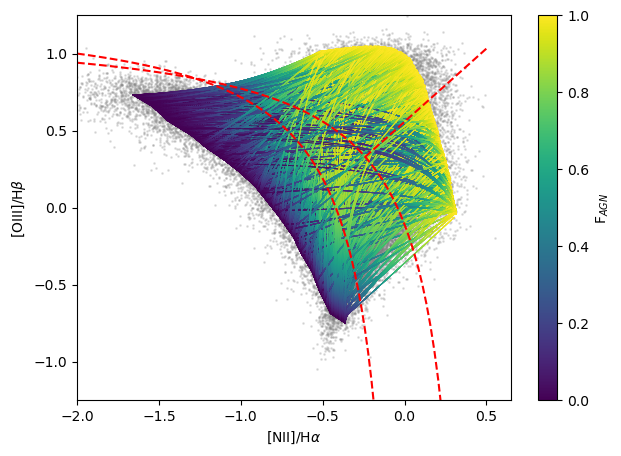

In [10]:
# visualize the tracks
plt.figure(figsize=(7, 5))
plt.scatter(eboss['x'], eboss['y'], c='tab:gray', s=1, alpha=0.2)
for i in range(N):
    plt.scatter(dfx[i], dfy[i], c=dfx.index.tolist(), edgecolor='none',  s=0.5)
plt.colorbar(label=r'F$_{AGN}$')
plt.clim(0, 1.0)
plt.plot(kewl_line()[0], kewl_line()[1], c='r', linestyle='dashed')
plt.plot(kauf_line()[0], kauf_line()[1], c='r', linestyle='dashed')
plt.plot(law_line()[0], law_line()[1], c='r', linestyle='dashed')
plt.xlim(-2, 0.65)
plt.ylim(-1.25, 1.25)
plt.xlabel(r'[NII]/H$\alpha$')
plt.ylabel(r'[OIII]/H$\beta$')
plt.show()

In [11]:
# function to generate the fractional AGN contribution dataframe
def f_agn_optimized(dfx, dfy, x, y, radius):
    distances = np.sqrt((dfx - x)**2 + (dfy - y)**2)
    mask = distances < radius
    result = distances.index[mask.any(axis=1)].tolist()
    
    if not result:
        return np.nan
    else:
        return result

In [12]:
# Generate x and y values
x_values = np.arange(-1.7, 0.33, 0.05)
y_values = np.arange(-0.75, 1.2, 0.05)

# Create a meshgrid
x_mesh, y_mesh = np.meshgrid(x_values, y_values)

# Flatten the meshgrid to get x and y values
x_flat = x_mesh.flatten()
y_flat = y_mesh.flatten()

# Create the DataFrame
dfgrid = pd.DataFrame({'x': x_flat, 'y': y_flat})

In [13]:
import time
# Record the start time
start_time = time.time()

frac_agn = dfgrid.apply(lambda row: f_agn_optimized(dfx, dfy, row['x'], row['y'], radius=0.025), axis=1)

end_time = time.time()

tot_time = end_time-start_time
print('For f_agn_optimizted', len(dfgrid), 'galaxies &', len(dfx), 'lines it takes ', tot_time, 'seconds')

For f_agn_optimizted 1599 galaxies & 2500 lines it takes  417.31269097328186 seconds


In [14]:
dfgrid['frac_agn'] = frac_agn
dfgrid['f_mean'] = dfgrid['frac_agn'].apply(np.nanmean)
dfgrid['f_median'] = dfgrid['frac_agn'].apply(np.median)
dfgrid['f_std'] = dfgrid['frac_agn'].apply(np.std)
dfgrid['f_var'] = dfgrid['frac_agn'].apply(np.var)

/Users/quinncasey/anaconda3/lib/python3.7/site-packages/pandas/core/apply.py:1101: RuntimeWarning: Mean of empty slice
  convert=self.convert_dtype,


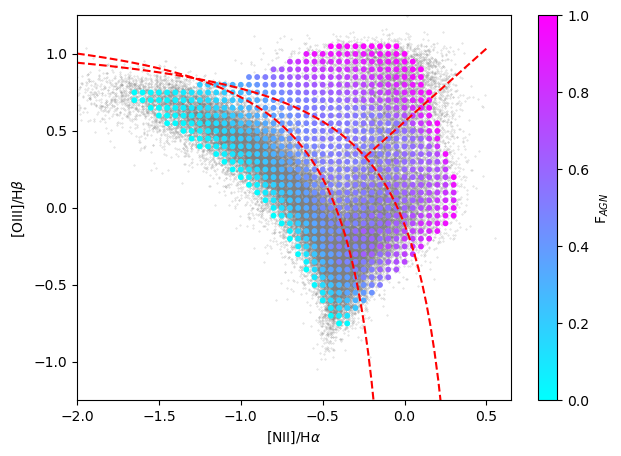

In [17]:
plt.figure(figsize=(7, 5))
plt.scatter(eboss['x'], eboss['y'], c='tab:gray', s=0.1, alpha=0.4)
plt.scatter(dfgrid['x'], dfgrid['y'], c=dfgrid['f_mean'], cmap='cool', marker='o', s=10)
plt.colorbar(label=r'F$_{AGN}$')
plt.clim(0, 1)
plt.plot(kewl_line()[0], kewl_line()[1], c='r', linestyle='dashed')
plt.plot(kauf_line()[0], kauf_line()[1], c='r', linestyle='dashed')
plt.plot(law_line()[0], law_line()[1], c='r', linestyle='dashed')
plt.xlim(-2, 0.65)
plt.ylim(-1.25, 1.25)
plt.xlabel(r'[NII]/H$\alpha$')
plt.ylabel(r'[OIII]/H$\beta$')
plt.show()

In [20]:
dfgrid.to_csv('/Users/quinncasey/pyme/f_agn/data/value_table.csv', index=None)

In [ ]:
def lookup_values(x, y):
    # Find the index of the closest x and y pair
    index = ((dfgrid['x'] - x)**2 + (dfgrid['y'] - y)**2).idxmin()
    
    # Retrieve values for the closest pair
    result = dfgrid.loc[index, ['f_mean', 'f_median', 'f_std', 'f_var']]
    
    if result.isna().all():
        print('Error: This point falls outside our model (sorry).')
    
    return result

In [ ]:
a, b, c, d = lookup_values([-0.05, -0.5], [1.05, 0.0])

In [ ]:
import tkinter as tk
from tkinter import ttk
from tkinter import messagebox

# GUI
def on_button_click():
    try:
        user_x = float(entry_x.get())
        user_y = float(entry_y.get())
    except ValueError:
        messagebox.showerror('Error', 'Please enter valid numeric values for x and y.')
        return

    result = lookup_values(user_x, user_y)
    if result.equals(pd.Series(['bad entry'] * len(result))):
        messagebox.showerror('Error:', 'This point falls outside our model (sorry).')
    else:
        result_str = ""
        #result_str += f"frac_agn: {result['frac_agn']}\n" if 'frac_agn' in result.index else ''
        result_str += f"Mean F-AGN: {np.round(result['f_mean'], 4)}\n" if 'f_mean' in result.index else ''
        result_str += f"Median F-AGN: {np.round(result['f_median'], 4)}\n" if 'f_median' in result.index else ''
        result_str += f"F-AGN Standard Deviation: {np.round(result['f_std'], 4)}\n" if 'f_std' in result.index else ''
        result_str += f"F-AGN Variance: {np.round(result['f_var'], 4)}\n" if 'f_var' in result.index else ''
        result_label.config(text=result_str)
        
def quit_application():
    root.destroy()
    

# Create GUI
root = tk.Tk()
root.title("BPT Fractional AGN Contribution")

# Entry widgets for user input
label_x = ttk.Label(root, text="Enter x:")
label_y = ttk.Label(root, text="Enter y:")
entry_x = ttk.Entry(root)
entry_y = ttk.Entry(root)

# Button to trigger the lookup
lookup_button = ttk.Button(root, text=r"Compute F-AGN", command=on_button_click)
quit_button = ttk.Button(root, text="Quit", command=quit_application)

# Label to display the result
result_label = ttk.Label(root, text="Results will be displayed here.")

# Pack widgets
label_x.pack(pady=5)
entry_x.pack(pady=5)
label_y.pack(pady=5)
entry_y.pack(pady=5)
lookup_button.pack(pady=10)
quit_button.pack(pady=5)
result_label.pack(pady=10)

# Run the GUI
root.mainloop()